In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.repository import get_dataset

In [2]:
dataset = get_dataset("electricity")
date_formater = mdates.DateFormatter("%Y")

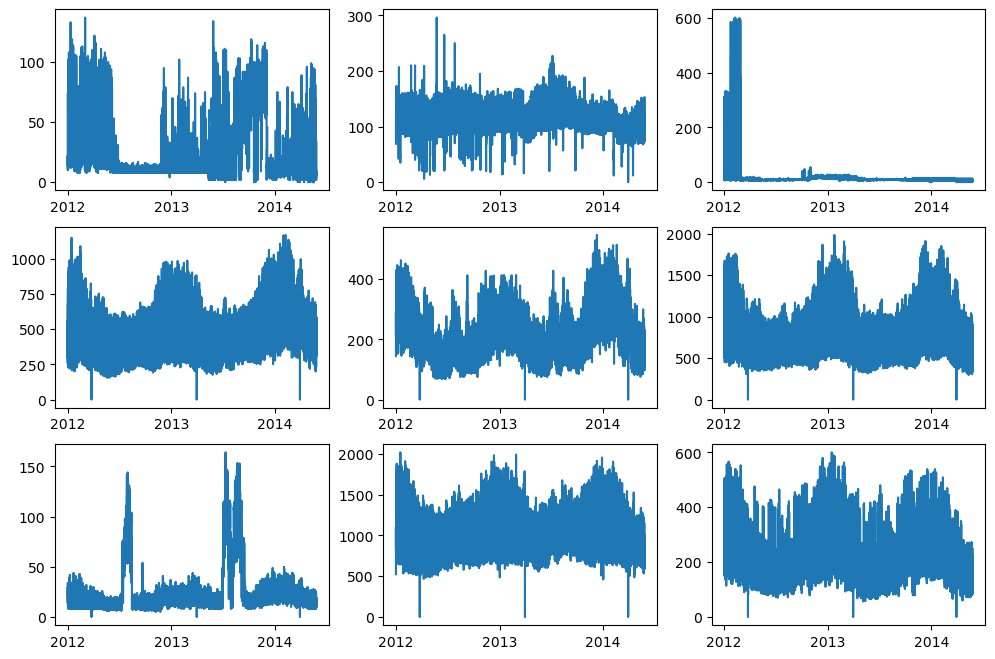

In [3]:
fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [10]:
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator
import torch.nn.functional as F
import math

In [6]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [11]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=500):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(dim * 2, proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # [1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table


class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation):
        super().__init__()
        self.dilated_conv = nn.Conv1d(
            residual_channels,
            2 * residual_channels,
            3,
            padding=dilation,
            dilation=dilation,
            padding_mode="circular",
        )
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.conditioner_projection = nn.Conv1d(
            1, 2 * residual_channels, 1, padding=2, padding_mode="circular"
        )
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)

        nn.init.kaiming_normal_(self.conditioner_projection.weight)
        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, x, conditioner, diffusion_step):
        diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)
        conditioner = self.conditioner_projection(conditioner)

        y = x + diffusion_step
        y = self.dilated_conv(y) + conditioner

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)

        y = self.output_projection(y)
        y = F.leaky_relu(y, 0.4)
        residual, skip = torch.chunk(y, 2, dim=1)
        return (x + residual) / math.sqrt(2.0), skip


class CondUpsampler(nn.Module):
    def __init__(self, cond_length, target_dim):
        super().__init__()
        self.linear1 = nn.Linear(cond_length, target_dim // 2)
        self.linear2 = nn.Linear(target_dim // 2, target_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = F.leaky_relu(x, 0.4)
        x = self.linear2(x)
        x = F.leaky_relu(x, 0.4)
        return x


class EpsilonTheta(nn.Module):
    def __init__(
        self,
        target_dim,
        cond_length,
        time_emb_dim=16,
        residual_layers=8,
        residual_channels=8,
        dilation_cycle_length=2,
        residual_hidden=64,
    ):
        super().__init__()
        self.input_projection = nn.Conv1d(
            1, residual_channels, 1, padding=2, padding_mode="circular"
        )
        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden
        )
        self.cond_upsampler = CondUpsampler(
            target_dim=target_dim, cond_length=cond_length
        )
        self.residual_layers = nn.ModuleList(
            [
                ResidualBlock(
                    residual_channels=residual_channels,
                    dilation=2 ** (i % dilation_cycle_length),
                    hidden_size=residual_hidden,
                )
                for i in range(residual_layers)
            ]
        )
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 3)
        self.output_projection = nn.Conv1d(residual_channels, 1, 3)

        nn.init.kaiming_normal_(self.input_projection.weight)
        nn.init.kaiming_normal_(self.skip_projection.weight)
        nn.init.zeros_(self.output_projection.weight)

    def forward(self, inputs, time, cond):
        x = self.input_projection(inputs)
        x = F.leaky_relu(x, 0.4)

        diffusion_step = self.diffusion_embedding(time)
        cond_up = self.cond_upsampler(cond)
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, cond_up, diffusion_step)
            skip.append(skip_connection)

        x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        x = self.skip_projection(x)
        x = F.leaky_relu(x, 0.4)
        x = self.output_projection(x)
        return x

In [16]:
from pts.modules import GaussianDiffusion, DiffusionOutput, MeanScaler, NOPScaler
from pts.model import weighted_average

In [14]:
from typing import List, Optional, Tuple, Union
from gluonts.core.component import validated

In [17]:
class FeedForwardNetwork(nn.Module):
    @validated()
    def __init__(self,
                 prediction_length : int,
                 context_length : int,
                 hidden_dim : List[int],
                 input_size : int,
                 num_layers: int,
                 num_cells: int,
                 history_length: int,
                 lags_seq: List[int],
                 conditioning_length: int,
                 target_dim : int,
                 residual_layers: int,
                 residual_channels: int,
                 dilation_cycle_length: int,
                 diff_steps: int,
                 loss_type: str,
                 beta_end: float,
                 beta_schedule: str,
                 batch_norm : bool =False,
                 ):
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dim) > 0
        
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dim = hidden_dim
        self.batch_norm = batch_norm
        self.target_dim = target_dim
        self.history_length = history_length

        lags_seq.sort()
        self.lags_seq = lags_seq

        dimensions = [context_length] + hidden_dim[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dim[-1]))

        self.nn = nn.Sequential(*modules) # 이걸 RNN 으로 바꾸면 됨 

        self.embed_dim = 1
        self.embed = nn.Embedding(
            num_embeddings=self.target_dim, embedding_dim=self.embed_dim
        )

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=num_cells,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
        )
        

        self.denoise_fn = EpsilonTheta(
            target_dim=target_dim,
            cond_length=conditioning_length,
            residual_layers=residual_layers,
            residual_channels=residual_channels,
            dilation_cycle_length=dilation_cycle_length,
        )

        self.diffusion = GaussianDiffusion(
            self.denoise_fn,
            input_size=target_dim,
            diff_steps=diff_steps,
            loss_type=loss_type,
            beta_end=beta_end,
            beta_schedule=beta_schedule,
        )

        self.distr_output = DiffusionOutput(
            self.diffusion, input_size=target_dim, cond_size=conditioning_length
        )

        self.scaler = MeanScaler(keepdim=True)

        # self.args_proj = self.distr_output.get_args_proj(hidden_dim[-1])

        self.proj_dist_args = self.distr_output.get_args_proj(num_cells)
    
    def unroll(
        self,
        lags: torch.Tensor,
        scale: torch.Tensor,
        time_feat: torch.Tensor,
        target_dimension_indicator: torch.Tensor,
        unroll_length: int,
        begin_state: Optional[Union[List[torch.Tensor], torch.Tensor]] = None,
    ):

        lags_scaled = lags / scale.unsqueeze(-1)

        input_lags = lags_scaled.reshape(
            (-1, unroll_length, len(self.lags_seq) * self.target_dim)
        )

        index_embeddings = self.embed(target_dimension_indicator)

        repeated_index_embeddings = (
            index_embeddings.unsqueeze(1).expand(-1, unroll_length, -1, -1).reshape((-1, unroll_length, self.target_dim * self.embed_dim))
        )

        inputs = torch.cat((input_lags, repeated_index_embeddings, time_feat), dim=-1)

        outputs, state = self.rnn(inputs, begin_state)

        return outputs, state, lags_scaled, inputs
    
    def distr_args(self, rnn_outputs: torch.Tensor):
        (distr_args,) = self.proj_dist_args(rnn_outputs)

        return distr_args
    
    def unroll_encoder(
        self,
        past_time_feat: torch.Tensor,
        past_target_cdf: torch.Tensor,
        past_observed_values: torch.Tensor,
        past_is_pad: torch.Tensor,
        future_time_feat: Optional[torch.Tensor],
        future_target_cdf: Optional[torch.Tensor],
        target_dimension_indicator: torch.Tensor,
    ):
        past_observed_values = torch.min(
            past_observed_values, 1 - past_is_pad.unsqueeze(-1)
        )

        if future_time_feat is None or future_target_cdf is None:
            time_feat = past_time_feat[:, -self.context_length :, ...]
            sequence = past_target_cdf
            sequence_length = self.history_length
            subsequences_length = self.context_length
        else:
            time_feat = torch.cat(
                (past_time_feat[:, -self.context_length :, ...], future_time_feat),
                dim=1,
            )
            sequence = torch.cat((past_target_cdf, future_target_cdf), dim=1)
            sequence_length = self.history_length + self.prediction_length
            subsequences_length = self.context_length + self.prediction_length

        lags = self.get_lagged_subsequences(
            sequence=sequence,
            sequence_length=sequence_length,
            indices=self.lags_seq,
            subsequences_length=subsequences_length,
        )

        _, scale = self.scaler(
            past_target_cdf[:, -self.context_length :, ...],
            past_observed_values[:, -self.context_length :, ...],
        )

        outputs, states, lags_scaled, inputs = self.unroll(
            lags=lags,
            scale=scale,
            time_feat=time_feat,
            target_dimension_indicator=target_dimension_indicator,
            unroll_length=subsequences_length,
            begin_state=None,
        )

        return outputs, states, scale, lags_scaled, inputs
    
    
    def forward(
            self,
            target_dimension_indicator: torch.Tensor,
            past_time_feat: torch.Tensor,
            past_target_cdf: torch.Tensor,
            past_observed_values: torch.Tensor,
            past_is_pad: torch.Tensor,
            future_time_feat: torch.Tensor,
            future_target_cdf: torch.Tensor,
            future_observed_values: torch.Tensor,
        ):
        
        # seq_len = self.context_length + self.prediction_length
        rnn_outputs, _, scale, _, _ = self.unroll_encoder(
            past_time_feat=past_time_feat,
            past_target_cdf=past_target_cdf,
            past_observed_values=past_observed_values,
            past_is_pad=past_is_pad,
            future_time_feat=future_time_feat,
            future_target_cdf=future_target_cdf,
            target_dimension_indicator=target_dimension_indicator,
        )

        target = torch.cat(
            (past_target_cdf[:, -self.context_length :, ...], future_target_cdf),
            dim=1,
        )
        # 여기 위에 까지 rnn 에 대한 이야기임
        
        distr_args = self.distr_args(rnn_outputs=rnn_outputs)
        likelihoods = self.diffusion.log_prob(target, distr_args).unsqueeze(-1)

        past_observed_values = torch.min(
            past_observed_values, 1 - past_is_pad.unsqueeze(-1)
        )

        observed_values = torch.cat(
            (
                past_observed_values[:, -self.context_length :, ...],
                future_observed_values,
            ),
            dim=1,
        )
        
        loss_weights, _ = observed_values.min(dim=-1, keepdim=True)

        loss = weighted_average(likelihoods, weights=loss_weights, dim=1)

        return (loss.mean(), likelihoods, distr_args)
    
    @staticmethod
    def get_lagged_subsequences(
        sequence: torch.Tensor,
        sequence_length: int,
        indices: List[int],
        subsequences_length: int = 1,
    ):
        
        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...].unsqueeze(1))
        return torch.cat(lagged_values, dim=1).permute(0, 2, 3, 1)


In [21]:
dataset.metadata.feat_static_cat[0].cardinality

'321'

In [22]:
dataset.metadata.prediction_length

24

In [32]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x0000014609D2E9B0>, iterable=JsonLinesFile(path=WindowsPath('C:/Users/chanyoung/.gluonts/datasets/electricity/train/data.json.gz'), start=0, n=None, line_starts=[0, 99765, 219425, 311220, 437626, 563490, 692880, 797608, 935044, 1060801, 1186302, 1311675, 1438007, 1563202, 1685326, 1811618, 1948126, 2053419, 2178889, 2306601, 2422220, 2527527, 2660503, 2770911, 2880809, 3007143, 3133045, 3259379, 3364994, 3491346, 3607287, 3733654, 3859988, 3985549, 4111092, 4258479, 4377402, 4503269, 4629833, 4747924, 4854184, 5001559, 5129496, 5255771, 5380387, 5506721, 5633055, 5747087, 5872103, 5987005, 6113338, 6239672, 6358731, 6485065, 6611399, 6723407, 6870936, 6997253, 7112777, 7243440, 7372822, 7500181, 7626455, 7752363, 7878697, 8002834, 8129168, 8255466, 8381687, 8502348, 8628527, 8746987, 8854100, 8980435, 9105856, 9232190, 9365051, 9491453, 9638028, 9764412, 9891391, 10021714, 10142391, 10268832, 10373998, 10485183, 10596334, 10702

In [24]:
from gluonts.dataset.util import to_pandas

In [29]:
entry

{'target': array([14., 18., 21., ...,  6.,  9.,  7.], dtype=float32),
 'start': Period('2012-01-01 00:00', 'H'),
 'feat_static_cat': array([0]),
 'item_id': 0}

In [35]:
next(iter(dataset.train))

{'target': array([14., 18., 21., ...,  6.,  9.,  7.], dtype=float32),
 'start': Period('2012-01-01 00:00', 'H'),
 'feat_static_cat': array([0]),
 'item_id': 0}

In [38]:
for idx, entry in enumerate(islice(dataset.train, 60)):
    train_series = to_pandas(entry)
    print(train_series)
    print('--------------------')

2012-01-01 00:00    14.0
2012-01-01 01:00    18.0
2012-01-01 02:00    21.0
2012-01-01 03:00    20.0
2012-01-01 04:00    22.0
                    ... 
2014-05-26 15:00     4.0
2014-05-26 16:00     8.0
2014-05-26 17:00     6.0
2014-05-26 18:00     9.0
2014-05-26 19:00     7.0
Freq: H, Length: 21044, dtype: float32
--------------------
2012-01-01 00:00     69.0
2012-01-01 01:00     92.0
2012-01-01 02:00     96.0
2012-01-01 03:00     92.0
2012-01-01 04:00     91.0
                    ...  
2014-05-26 15:00    106.0
2014-05-26 16:00    104.0
2014-05-26 17:00    110.0
2014-05-26 18:00    115.0
2014-05-26 19:00    119.0
Freq: H, Length: 21044, dtype: float32
--------------------
2012-01-01 00:00    234.0
2012-01-01 01:00    312.0
2012-01-01 02:00    312.0
2012-01-01 03:00    312.0
2012-01-01 04:00    312.0
                    ...  
2014-05-26 15:00      7.0
2014-05-26 16:00      8.0
2014-05-26 17:00      8.0
2014-05-26 18:00     10.0
2014-05-26 19:00      8.0
Freq: H, Length: 21044, dtype: fl

In [28]:
train_series

2012-01-01 00:00    14.0
2012-01-01 01:00    18.0
2012-01-01 02:00    21.0
2012-01-01 03:00    20.0
2012-01-01 04:00    22.0
                    ... 
2014-05-26 15:00     4.0
2014-05-26 16:00     8.0
2014-05-26 17:00     6.0
2014-05-26 18:00     9.0
2014-05-26 19:00     7.0
Freq: H, Length: 21044, dtype: float32

In [8]:
import lightning.pytorch as pl

In [30]:
dataset.metadata

MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='321')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [31]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

In [39]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [44]:
len(dataset_train)

1

In [ ]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer